In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

# linear regression statistics
from scipy.stats import linregress

# Packages for Supervised ML - Linear Regression
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import boxcox

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

sns.set_style('whitegrid')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def printLinearRegression(column_x, column_y):
    """
    Inputs a dependent variable and independent variable and outputs linear regression.
    Args:
        column_x (pandas.series) : independent variable (predictor variable)
        column_y (pandas.series) : dependent variable (outcome variable)
    Returns:
        print statemenmt (str) containing slope, intercept, and R^2 value.
    """
    slope, intercept, r_value, _, _ = linregress(column_x, column_y)
    r_squared = r_value ** 2

    print(f'{column_y.name.title()} vs {column_x.name.upper()} Linear Regression:')
    print('--- ' * 8)
    print(f'Slope: {slope} \n Intercept: {intercept} \n r_squared: {r_squared}')
    return None

def log_transform(column):
    """
    Log transforms data. Transform right skewed data to approximately normal.
    Args:
        column (pandas.series) : data to be transformed
    Returns:
        np.log(column)
    """
    return np.log(column)

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log(X)

# Columns
1. __age__ : age of primary beneficiary 
2. __sex__ : insurance contractor's gender
    - male or female
3. __bmi__ : body mass indec
    - providing an understanding of body
    - weights that are relatively high or low relative to height
    - objective index of body weight (kg / m ^ 2) using the ratio of height to weight 
        - (ideally 18.5 to 24.9)
            - under 18.5 : underweight
            - between 18.5 and 24.9 : 'healthy range'
            - between 25 and 29.9 : overweight
            - between 30 and 39.9 : obesity
            - 40 or over : severe obesity
4. __children__ : number of children covered by health insurance / number of dependents
5. __smoker__ : if they smoke
6. __region__ : beneficiary's residentail area in the US
    - northeast, southease, southwest, northwest
7. __charges__ : individual medical costs billed by health insurance

# Goal

Predict cost of insurance per beneficiary.

In [3]:
# import data
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# convert object data types to string
df['sex'] = df['sex'].astype('str')
df['smoker'] = df['smoker'].astype('str')
df['region'] = df['region'].astype('str')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Based on these cells, there does not seem to be any blank data. We have to explore this further as missing data may be represented by strings of any type. 
    Age:
        - avg is around 40 y/o
        - data seems to be pretty gaussian
    bmi
        - avg is around 30 (obesity)

In [7]:
# Dealing with missing data
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
# Looking for outliers
numeric_data = df.select_dtypes(include=['float', 'int'])
numeric_data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


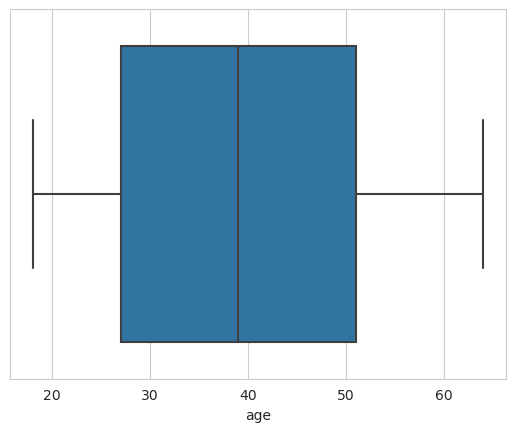

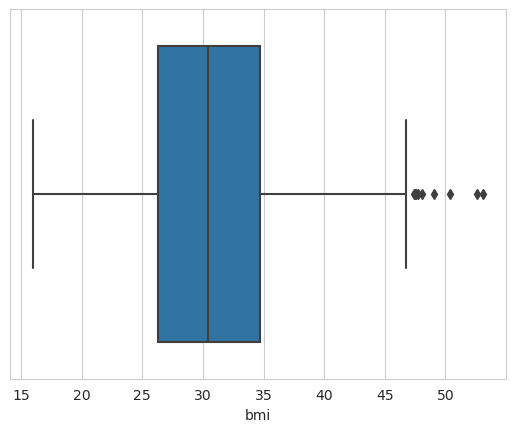

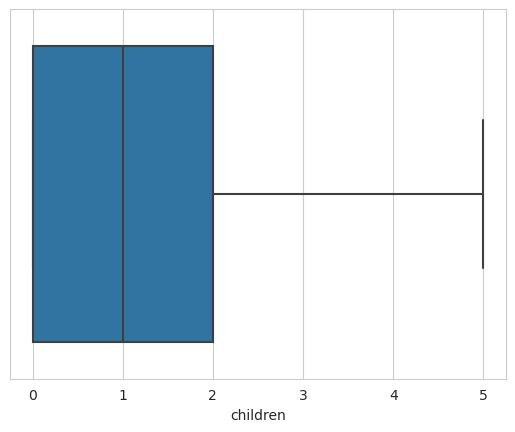

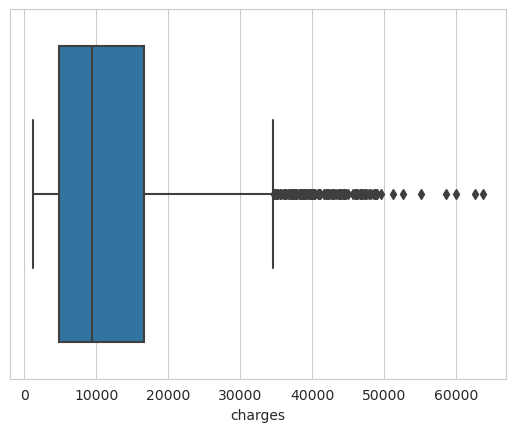

In [9]:
numeric_cols = list(numeric_data.columns)

for col in numeric_cols:
    sns.boxplot(x=numeric_data[col])
    plt.xlabel(col)
    plt.show()

The outliers are mostly seenin BMI and charge values. However, based on domain knowledge, these outliers are not of abdormal origin and do not compromise the dataset. 

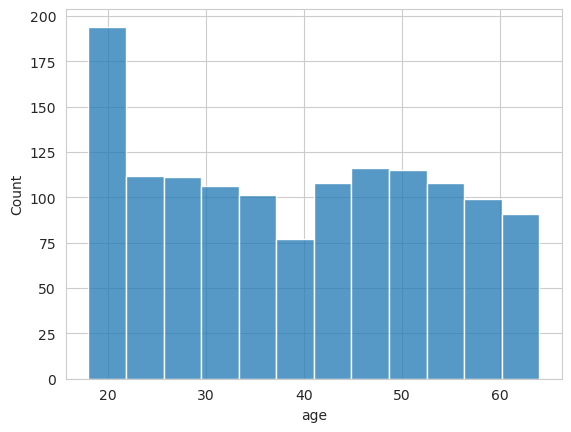

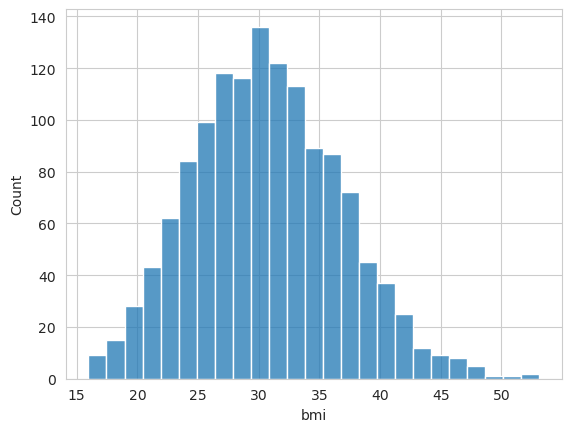

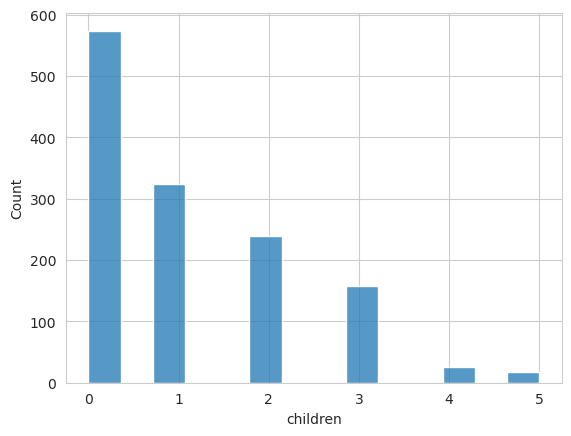

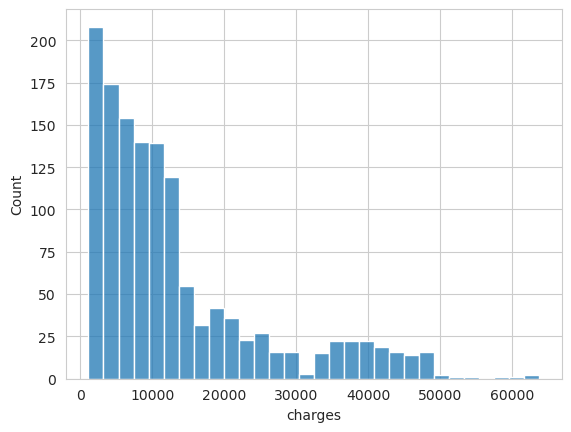

In [10]:
for col in numeric_cols:
    sns.histplot(x=numeric_data[col])
    plt.xlabel(col)
    plt.show()

Distributions:
- age is fairly uniform with a major peak in the 20's, a small peak in the 50's, and a low point in the 40's
- bmi has a normal distribution
- number of children is right skewed (makes sense as people have closer to 0-2 kids vs 2+)
- charges are heavily right skewed with most charges between 0-15,000 dollars
    - mean: 13270.422265, std: 2110.011237, median: 9382.033

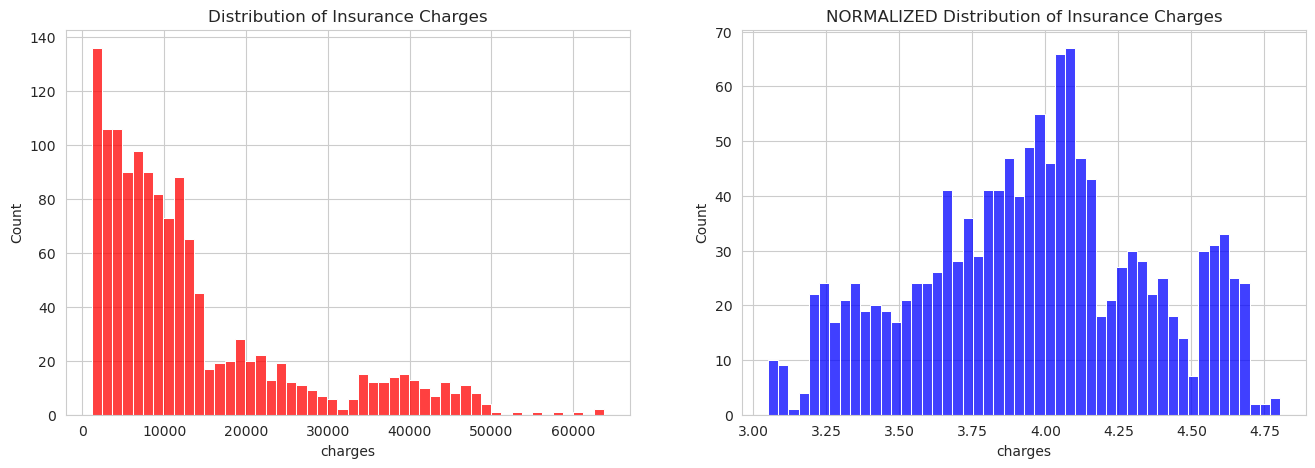

In [11]:
fig, ax = plt.subplots(1, 2,figsize=(16,5))

sns.histplot(df['charges'], bins=50, color='r', ax=ax[0])
ax[0].set_title('Distribution of Insurance Charges')


sns.histplot(np.log10(df['charges']), bins=50, color='b', ax=ax[1])
ax[1].set_title('NORMALIZED Distribution of Insurance Charges')

plt.show()

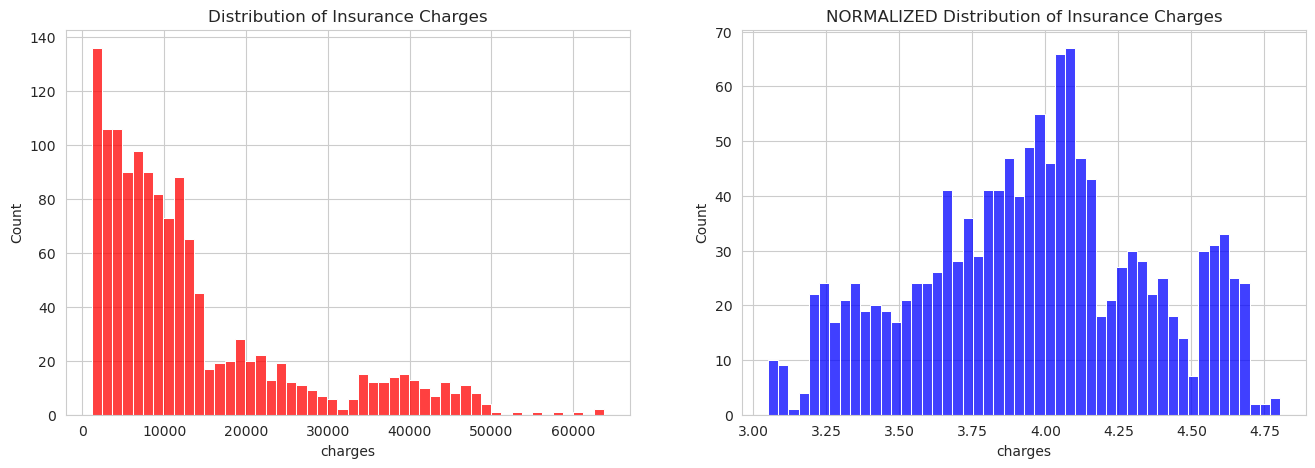

In [12]:
fig, ax = plt.subplots(1, 2,figsize=(16,5))

sns.histplot(df['charges'], bins=50, color='r', ax=ax[0])
ax[0].set_title('Distribution of Insurance Charges')

sns.histplot(np.log10(df['charges']), bins=50, color='b', ax=ax[1])
ax[1].set_title('NORMALIZED Distribution of Insurance Charges')

plt.show()

Using logarithmic normalization, we see that charge approaches a more gaussian distribution. 

np.log10() is a function in NumPy that calculates the base-10 logarithm of elements in an array. When you apply np.log10() to a distribution that is positively skewed (i.e., skewed to the right), it can help reduce the magnitude of extreme values and make the distribution less skewed.

In positively skewed distributions, there is a long tail on the right side, indicating that there are some large values that pull the mean and median towards the right. By taking the logarithm of the data, the values in the right tail get compressed, which can reduce the overall skewness of the distribution.

### Exploration using violinplots

sns.violinplot is a function in the Seaborn library, used for visualizing the distribution of a continuous variable or numeric data across different categories. It combines the features of a box plot and a kernel density plot to provide a more comprehensive representation of the data distribution.

The main purpose of sns.violinplot is to:

1. Show the distribution of data: The width of the violin at a particular point represents the density of data at that value. Wider sections indicate more data points, while narrower sections represent fewer data points.

2. Visualize data across categories: It is useful for comparing the distribution of a continuous variable among different groups or categories in the dataset.

sns.violinplot will create a violin plot of the data variable across the different categories specified in the category variable. The plot will display the distribution of data within each category using violin-shaped representations.

The central white dot inside the violins represents the median value of the data within each category, and the thick black bar inside the violins represents the interquartile range (IQR). The thin lines extending from the violins, known as "whiskers," indicate the range of the data.

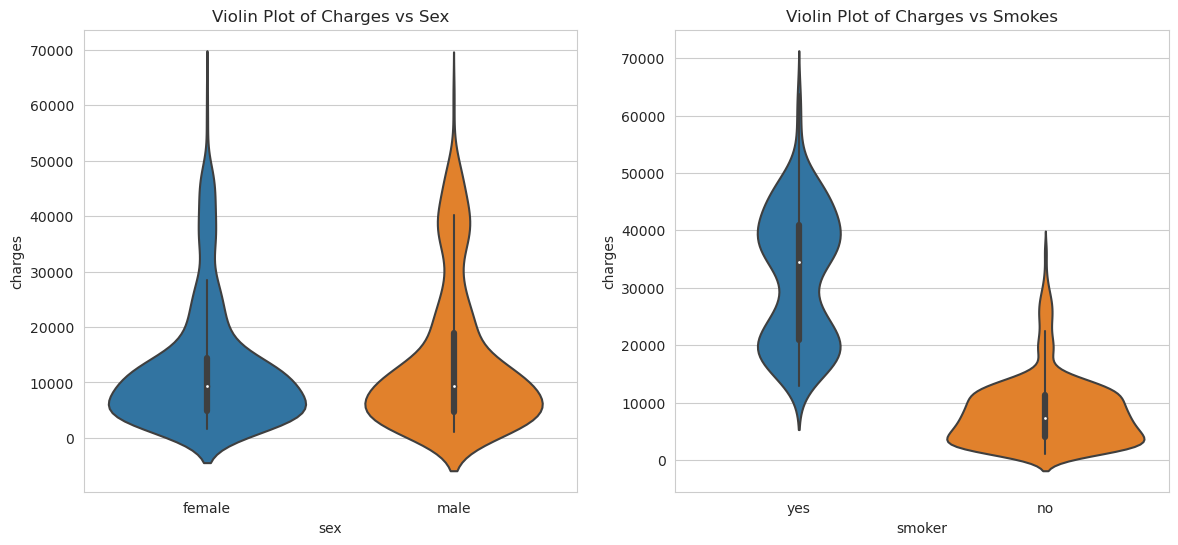

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.violinplot(x='sex', y='charges', data=df, ax=ax[0])
ax[0].set_title('Violin Plot of Charges vs Sex')

sns.violinplot(x='smoker', y='charges', data=df, ax=ax[1])
ax[1].set_title('Violin Plot of Charges vs Smokes')

plt.show()

### Exploration using jointplots

The main purpose of sns.jointplot is to help identify patterns, correlations, and potential relationships between two variables. It is particularly useful when exploring bivariate relationships, especially in the context of statistical analysis and data exploration.

sns.jointplot will create a scatter plot of x and y variables and display histograms of each variable along the corresponding axes. This allows you to see the joint distribution of x and y and also observe the distribution of each variable separately.



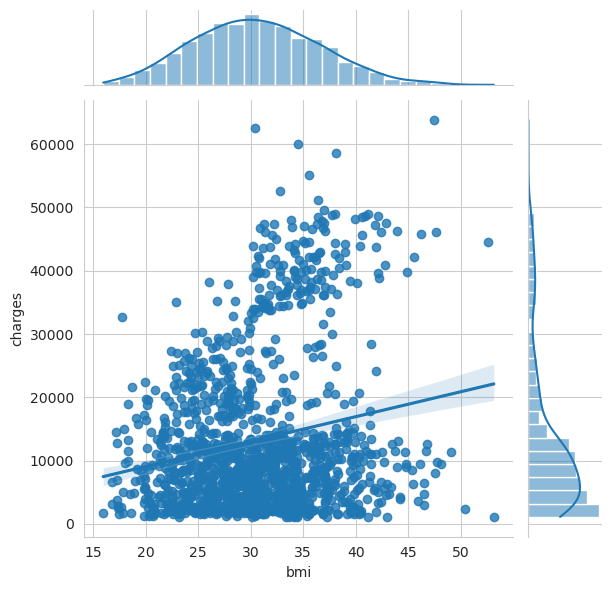

In [14]:
sns.jointplot(x='bmi', y='charges', data=df, kind='reg')
plt.show()

In [15]:
printLinearRegression(df['bmi'], df['charges'])

Charges vs BMI Linear Regression:
--- --- --- --- --- --- --- --- 
Slope: 393.8730307973953 
 Intercept: 1192.937208961148 
 r_squared: 0.03933913991786257


Overall trend of increased BMI leading to increased charges.

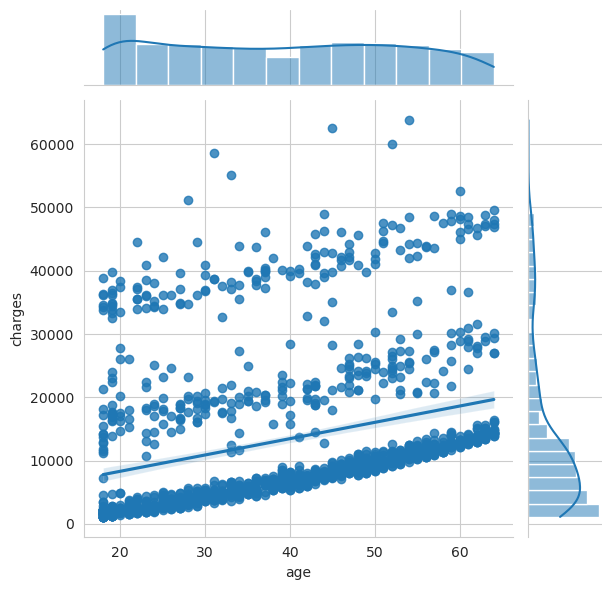

In [16]:
sns.jointplot(x='age', y='charges', data=df, kind='reg')
plt.show()

In [17]:
printLinearRegression(df['age'], df['charges'])

Charges vs AGE Linear Regression:
--- --- --- --- --- --- --- --- 
Slope: 257.7226186668954 
 Intercept: 3165.8850060630302 
 r_squared: 0.08940589967885793


Overall trend of increased age leading to increased charges.

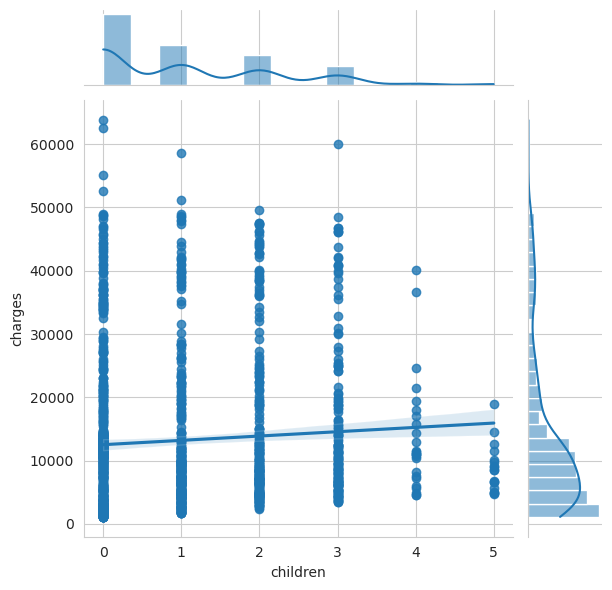

In [18]:
sns.jointplot(x='children', y='charges', data=df, kind='reg')
plt.show()

In [19]:
printLinearRegression(df['children'], df['age'])

Age vs CHILDREN Linear Regression:
--- --- --- --- --- --- --- --- 
Slope: 0.4949741523991007 
 Intercept: 38.665069407126545 
 r_squared: 0.0018036158385915557


Overall trend between charges vs age/dependents is near 0 with an R^2 of .001.

In [20]:
# Is there correlation between variables?

numeric_data.drop(columns=['charges']).corr()

,age,bmi,children
age,1.000000,0.109272,0.042469
bmi,0.109272,1.000000,0.012759
children,0.042469,0.012759,1.000000


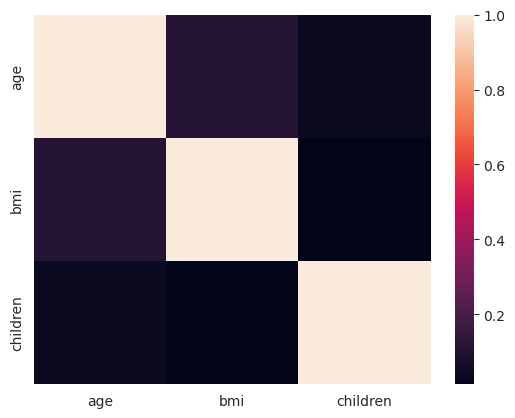

In [21]:
sns.heatmap(data=numeric_data.drop(columns=['charges']).corr())
plt.show()

### Numeric Multicollinearity
Between the variables, there is slight correlation between BMI and AGE. This can be indicitive of multicollinearity between the two variables. 

### Categorical Multicollinearity
In categorical data, when preprocessing for ML, the categories are often seperated out into "dummy variables" where each category will get it's own column. However, using "dummy variables" can lead to multicollinearity.

This called the Dummy Variable Trap.

The Dummy variable trap is a scenario where there are attributes that are highly correlated (Multicollinear) and one variable predicts the value of others. When we use one-hot encoding for handling the categorical data, then one dummy variable (attribute) can be predicted with the help of other dummy variables. Hence, one dummy variable is highly correlated with other dummy variables. Using all dummy variables for regression models leads to a dummy variable trap. So, the regression models should be designed to exclude one dummy variable. 

In [22]:
# create new dataframe that will include dummy variables
df_encode = df.copy()
df_encode = pd.get_dummies(data=df_encode, columns=['sex', 'smoker', 'region'])
df_encode.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [23]:
# normalize charges data using boxcox transformation
y_bc, lam, ci = boxcox(df_encode['charges'], alpha=0.05)

- y_bc: This variable stores the transformed 'charges' data after applying the Box-Cox transformation.
- lam: This variable stores the estimated lambda parameter obtained from the Box-Cox transformation. The lambda parameter is automatically estimated to achieve the best normalization for the data.
- ci: This variable stores the confidence interval for the lambda parameter. It is calculated in case you want to test the significance of the transformation.

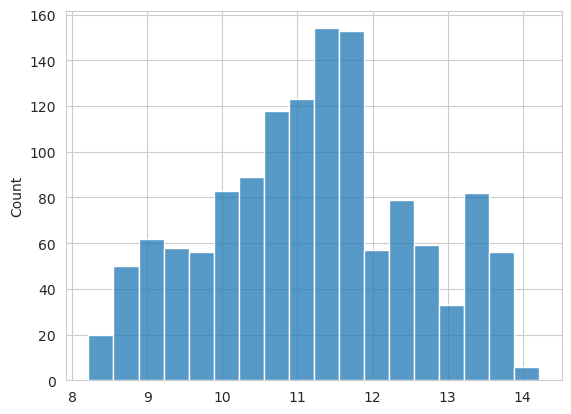

In [24]:
sns.histplot(y_bc);

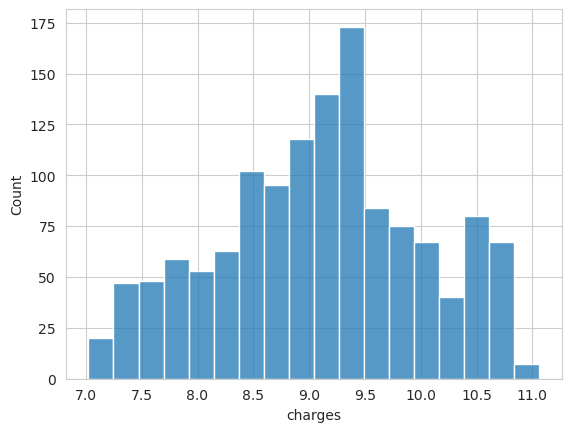

In [25]:
# noramlize charges data using log() since right skewed
y_log = np.log(df['charges'])
sns.histplot(y_log);

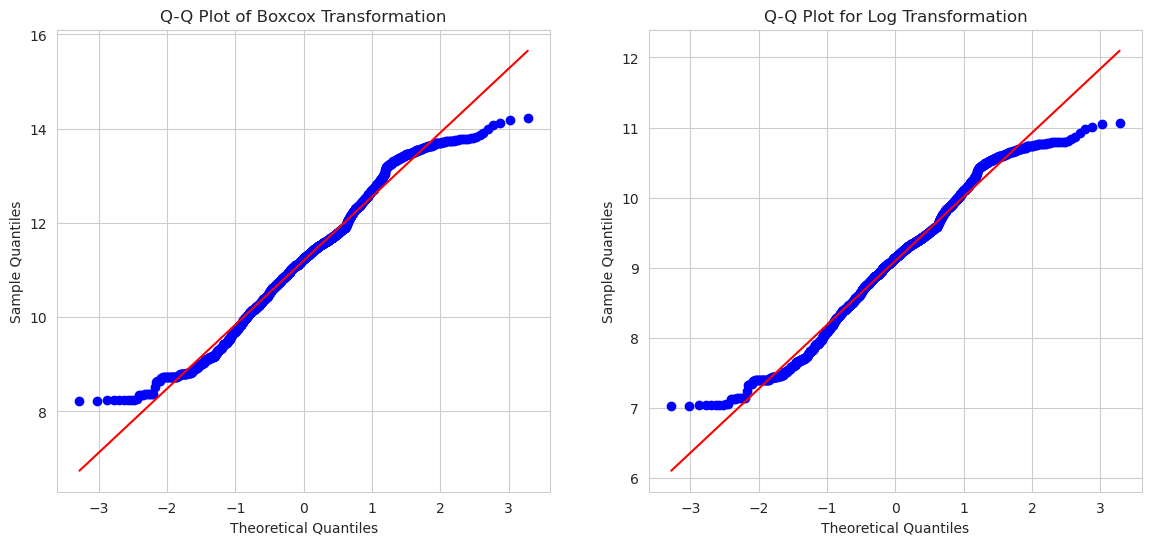

In [26]:
# Generate Q-Q plots
fig, ax = plt.subplots(1, 2, figsize=(14,6))

stats.probplot(y_bc, dist="norm", plot=ax[0])
ax[0].set_xlabel("Theoretical Quantiles")
ax[0].set_ylabel("Sample Quantiles")
ax[0].set_title("Q-Q Plot of Boxcox Transformation")

stats.probplot(y_log, dist="norm", plot=ax[1])
ax[1].set_xlabel("Theoretical Quantiles")
ax[1].set_ylabel("Sample Quantiles")
ax[1].set_title("Q-Q Plot for Log Transformation")


plt.show()

In [27]:
# Perform Shapiro-Wilk test
shapiro_bc = stats.shapiro(y_bc)
shapiro_log = stats.shapiro(y_log)

# Extract test statistics and p-values
statistic_bc, p_value_bc = shapiro_bc
statistic_log, p_value_log = shapiro_log

# Print the results
print("Shapiro-Wilk Test for y_bc:")
print(f"Test Statistic: {statistic_bc:.4f}, p-value: {p_value_bc:.4f}")
if p_value_bc > 0.05:
    print("The data in y_bc appears to be normally distributed.")
else:
    print("The data in y_bc does not appear to be normally distributed.")

print("\nShapiro-Wilk Test for y_log:")
print(f"Test Statistic: {statistic_log:.4f}, p-value: {p_value_log:.4f}")
if p_value_log > 0.05:
    print("The data in y_log appears to be normally distributed.")
else:
    print("The data in y_log does not appear to be normally distributed.")

Shapiro-Wilk Test for y_bc:
Test Statistic: 0.9835, p-value: 0.0000
The data in y_bc does not appear to be normally distributed.

Shapiro-Wilk Test for y_log:
Test Statistic: 0.9832, p-value: 0.0000
The data in y_log does not appear to be normally distributed.


While the two transformatoins improve the right skew, they do not reach a normal distribution. However, between boxcox and log(), boxcox is very very slightly more normal than the log transformation.

In [28]:
df_encode['charges'] = y_bc
df_encode.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,12.128980,1,0,0,1,0,0,0,1
1,18,33.770,1,8.808596,0,1,1,0,0,0,1,0
2,28,33.000,3,10.147521,0,1,1,0,0,0,1,0
3,33,22.705,0,12.534950,0,1,1,0,0,1,0,0
4,32,28.880,0,9.945637,0,1,1,0,0,1,0,0


### Split the data
- seperate features from outcome variable
- split into train and test 

In [29]:
X = df.drop(columns=['charges'])
y = np.log10(df['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

### Create pipeline

In [30]:
# seperate cols based on dtypes
numeric_cols = df.drop(columns=['charges']).select_dtypes(include=[np.number]).columns.to_list()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.to_list()

# Create Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), numeric_cols)
    ], remainder='passthrough'
)

model = LinearRegression()

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('LinearRegression', model)
    ])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('LinearRegression', LinearRegression())])

In [32]:
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.19193200305406297


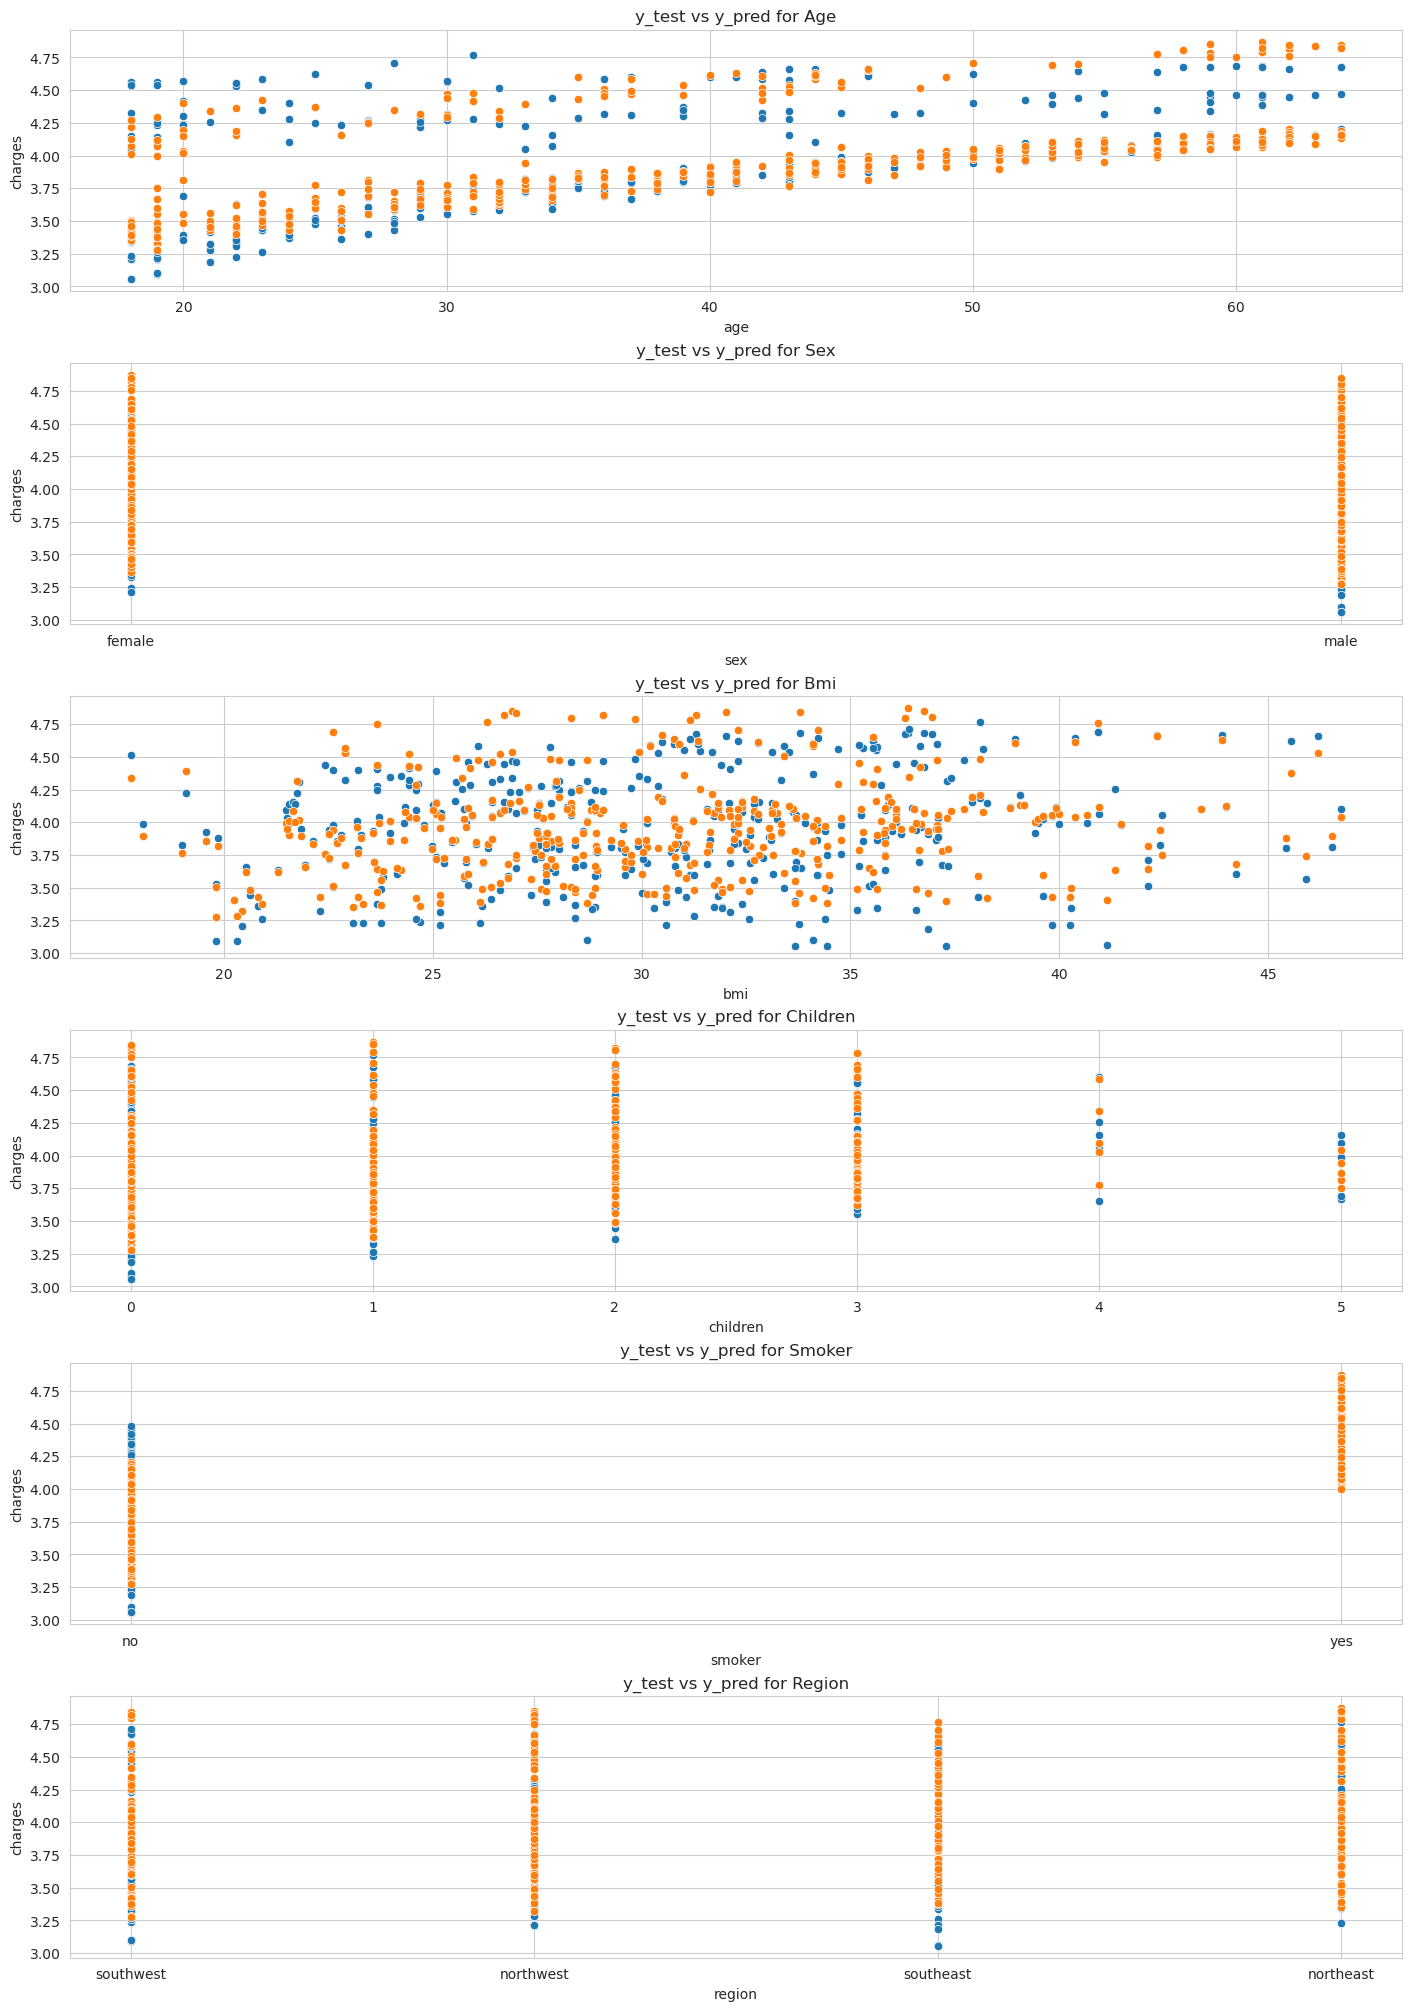

In [33]:
# visualize each independent variable with the test/predictor
fig, ax = plt.subplots(6, 1, figsize=(14,20), constrained_layout=True)

for i in range(len(X_test.columns)):
    sns.scatterplot(x=X_test.iloc[:,i], y=y_test, ax=ax[i])
    sns.scatterplot(x=X_test.iloc[:,i], y=y_pred, ax=ax[i])
    ax[i].set_title(f'y_test vs y_pred for {X_test.columns[i].title()}')


plt.show()

In [34]:
# create table with test and prediction together
compare_prediction = pd.DataFrame({'Test': y_test,
    'Prediction' : y_pred})
compare_prediction.sample(20)

,Test,Prediction
339,3.915539,3.896653
1094,4.053053,4.029425
243,3.857143,3.922627
168,3.434454,3.557325
1185,3.934691,3.914896
963,3.977750,3.952474
197,3.930278,3.915367
224,4.290381,4.424081
1177,3.812705,3.823913
583,4.246160,3.644265


In [35]:
# calculate the R-squared value for results
corr_matrix = np.corrcoef(y_test, y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)

0.7762830118473965


In [36]:
# verify with correlation between Test and Prediction
compare_prediction.corr() ** 2

,Test,Prediction
Test,1.000000,0.776283
Prediction,0.776283,1.000000
